### Selecting the correct device for training (CPU or GPU)

In [1]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

load_data_on_GPU = True

Using cuda device


# Importing the Data

In [2]:
from dataset import CS9DataReader

data_reader = CS9DataReader(root_dir="../data/CrackSeg9k/", mode="Test", load_on_gpu=load_data_on_GPU, verbose=True)
test_data = data_reader.data

Loading dataset into GPU:   0%|          | 0/1486 [00:00<?, ?it/s]

	- Loading done, GPU memory used: 0.89GiB / free: 9.25GiB / total: 10.91GiB
	- Got a total of 1486 images.


In [3]:
from torch.nn.functional import normalize

from pipelines import InputPipeline, LaplacianFilter

inpip = InputPipeline(
    transformer=[normalize],
    layer_transformer=[LaplacianFilter()]
)

inpip = inpip.to(device)

### Creating Evaluation Dataset

In [4]:
from torch.nn.functional import normalize

from dataset import CS9Dataset

test_dataset = CS9Dataset(test_data, transform=inpip, target_transform=None, load_on_gpu=load_data_on_GPU, verbose=True)

	- Loading done, GPU memory used: 0.89GiB / free: 9.25GiB / total: 10.91GiB


In [5]:
from torch.utils.data import DataLoader

if load_data_on_GPU:
    evaluation_dataloader = DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=True,
    )
else:
    evaluation_dataloader = DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=True,
        num_workers=20,
        pin_memory=True,
        pin_memory_device=device,
    )

### Testing the dataloader

torch.Size([1, 4, 400, 400]) torch.Size([1, 2, 400, 400])
('Rissbilder_for_Florian_9S6A2896_28_1443_3701_3540.png',) tensor([984])


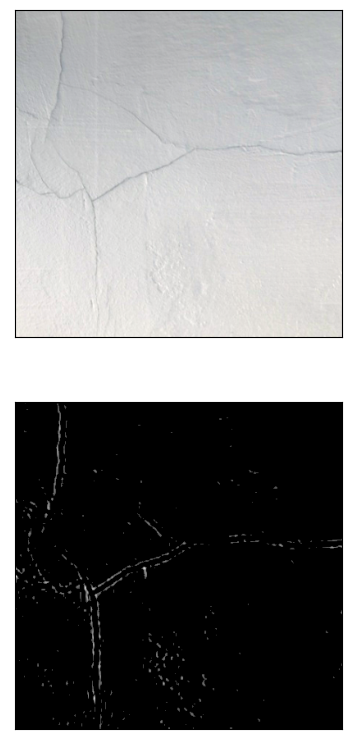

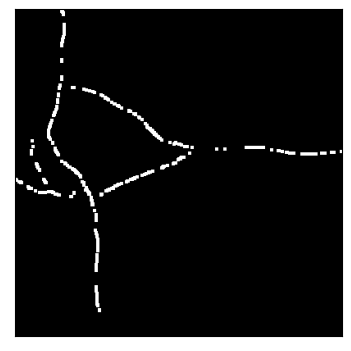

In [22]:
from my_utils import show_img

features, masks, files, indexes = next(iter(evaluation_dataloader))
print(features.size(), masks.size())

show_img(features)
show_img(masks)
print(files, indexes)

# Building the differents modules

## Creating the models

#### Using Unet with bilinear upsampling and cropping to generate 2 classes (background and crack).

In [7]:
from models import UNet

model = UNet(n_channels=inpip.nb_channel, n_classes=2, bilinear=True, crop=False).to(device)

In [8]:
model_state, _, _ = torch.load("../best_model/checkpoint.pt")
model.load_state_dict(model_state)

<All keys matched successfully>

## Creating the Metrics

In [11]:
from metrics import EvaluationMetrics

test_metrics = EvaluationMetrics(
    buffer_size=len(evaluation_dataloader),
    hyperparam={
        'Network': "UNet",
        'Optimizer': "Adam",
        'Combine Loss': "CombinedLoss",
        'Pixel Loss': "FocalLoss",
        'Volume Loss': "JaccardLoss",
        'Input Filter': None,
        'Input Layer': "LaplacianFilter",
        'Batch Size': 4,
        'Learning Rate': 1e-4,
        'Negative Mining': False,
        'Smooth Labeling': False,
    },
    epochs=10,
    device=device)

# Validating the Dataset

In [55]:
from train_tqdm import evaluation_loop

evaluation_loop(evaluation_dataloader, model, test_metrics, device)

test_metrics.close_tensorboard()

[Evaluating]:   0%|          | 0/1486 [00:00<?, ?it/s]

(tensor([0], device='cuda:0'), tensor([160000], device='cuda:0'))
